# Clustering FEB3 Players

## Fase prèvia

Primer de tot carregarem les llibreries necessàries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

Configurarem la paleta visual pels gràfics.

In [2]:
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

Carreguem el nostre dataset de jugadors.

In [3]:
df = pd.read_csv('feb_gold_dataset.csv')
print(f"Dataset carregat: {df.shape}")

Dataset carregat: (12708, 32)


Seleccionarem les features necessàries pel model.

In [4]:
features_model = [
    # Eficiència
    'oer', 'der_proxy', 'ts_pct',
    # Estil
    'usage_2p', 'usage_3p', 'ftr', 
    'pct_interior_usage', 'pct_exterior_usage', 'pct_shots_corner3',
    # Eficàcia Zona
    'eff_paint', 'eff_mid', 'eff_corner3', 'eff_ab3',
    # Volum P40
    'pts_p40', 'orb_p40', 'drb_p40', 
    'ast_p40', 'stl_p40', 'blk_p40', 'tov_p40',
    'pfd_p40', 'fga_p40', '3pa_p40', 'fta_p40'
]

Un cop tenim les features necessàries hem d'escalar les dades ja que és imprescindible pel k-means.

In [5]:
X = df[features_model]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_model)

print("Dades escalades i llestes per al K-Means!")
display(X_scaled_df.head())

Dades escalades i llestes per al K-Means!


,oer,der_proxy,ts_pct,usage_2p,usage_3p,ftr,pct_interior_usage,pct_exterior_usage,pct_shots_corner3,eff_paint,eff_mid,eff_corner3,eff_ab3,pts_p40,orb_p40,drb_p40,ast_p40,stl_p40,blk_p40,tov_p40,pfd_p40,fga_p40,3pa_p40,fta_p40
0,-0.407602,-0.151293,-0.653012,-0.979896,1.168528,-0.758027,-0.777651,-0.784218,-0.318675,-0.823346,-0.611647,-0.419686,-0.669915,-0.976464,-0.588699,-0.402400,0.762593,-0.860866,-0.436765,-0.628504,-0.185372,-0.732648,0.205654,-0.828545
1,-0.162077,-0.402411,-0.072708,-0.014637,0.151445,-0.294667,-0.777651,-0.784218,-0.318675,-0.823346,-0.611647,-0.419686,-0.669915,0.784599,-0.652204,0.205547,-0.191139,-0.158685,-0.436765,0.342790,0.041077,1.444865,0.830403,0.154806
2,0.148271,-0.208783,0.380915,0.250901,-0.128350,-0.037629,-0.777651,-0.784218,-0.318675,-0.823346,-0.611647,-0.419686,-0.669915,1.030608,-0.397248,0.634032,-0.175942,-0.028687,-0.256281,0.064795,0.508585,1.037564,0.297441,0.409271
3,0.442030,-0.212197,0.500292,0.243278,-0.120318,-0.212642,-0.777651,-0.784218,-0.318675,-0.823346,-0.611647,-0.419686,-0.669915,1.347357,0.333949,0.347420,-0.212438,0.124660,-0.148577,-0.435294,0.275929,1.348260,0.445535,0.257128
4,0.140401,-0.218698,0.151444,0.242715,-0.119724,0.042797,-0.777651,-0.784218,-0.318675,-0.823346,-0.611647,-0.419686,-0.669915,0.974646,0.067845,0.504546,0.236835,0.141650,-0.436765,-0.235120,0.693883,1.228984,0.392847,0.613209


## Dades sense clusteritzar

Veurem les dades sense clusteritzar per veure com es distribueixen.

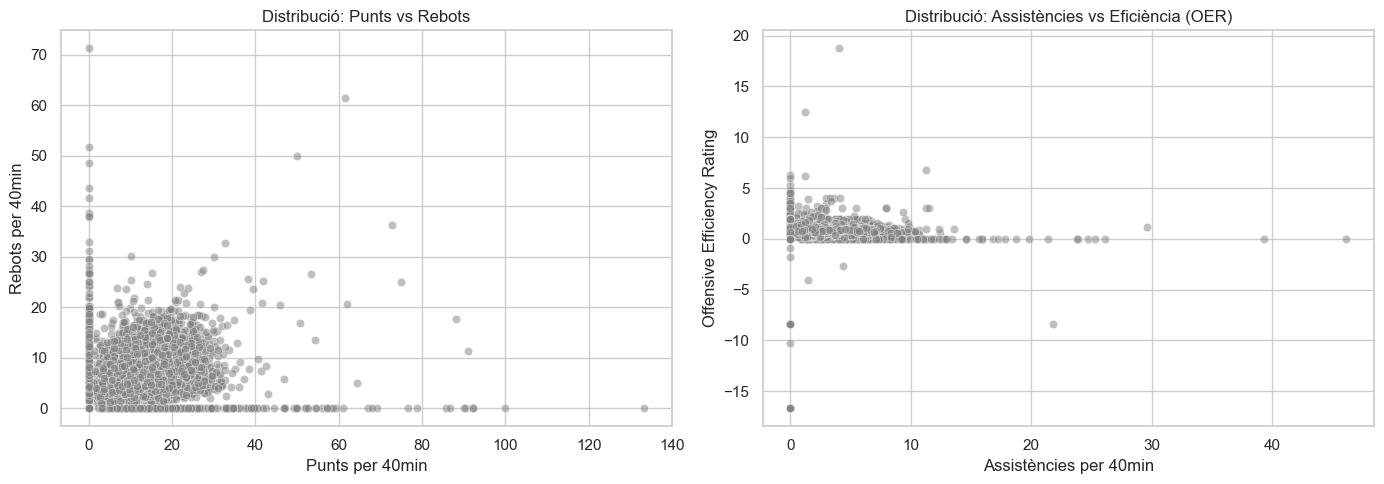

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    data=df, x="pts_p40", y="trb_p40",
    color="grey", alpha=0.5, ax=axes[0]
)
axes[0].set_title("Distribució: Punts vs Rebots")
axes[0].set_xlabel("Punts per 40min")
axes[0].set_ylabel("Rebots per 40min")

sns.scatterplot(
    data=df, x="ast_p40", y="oer",
    color="grey", alpha=0.5, ax=axes[1]
)
axes[1].set_title("Distribució: Assistències vs Eficiència (OER)")
axes[1].set_xlabel("Assistències per 40min")
axes[1].set_ylabel("Offensive Efficiency Rating")

plt.tight_layout()
plt.show()

## Elecció de K

Per escollir la millor K pel nostre model utilitzarem inertia i silhouette_scores. Anem a crear unes llistes per guardar els resultats.

In [7]:
inertia = []
silhouette_scores = []

Definim també el rang de K que provarem, nosaltres provarem de 2 a 12 clústers.

In [8]:
K_range = range(2, 12)

Entrenem el k-means amb els diferents clústers definits.

In [9]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

Mostrarem dues gràfiques per veure els resultats.

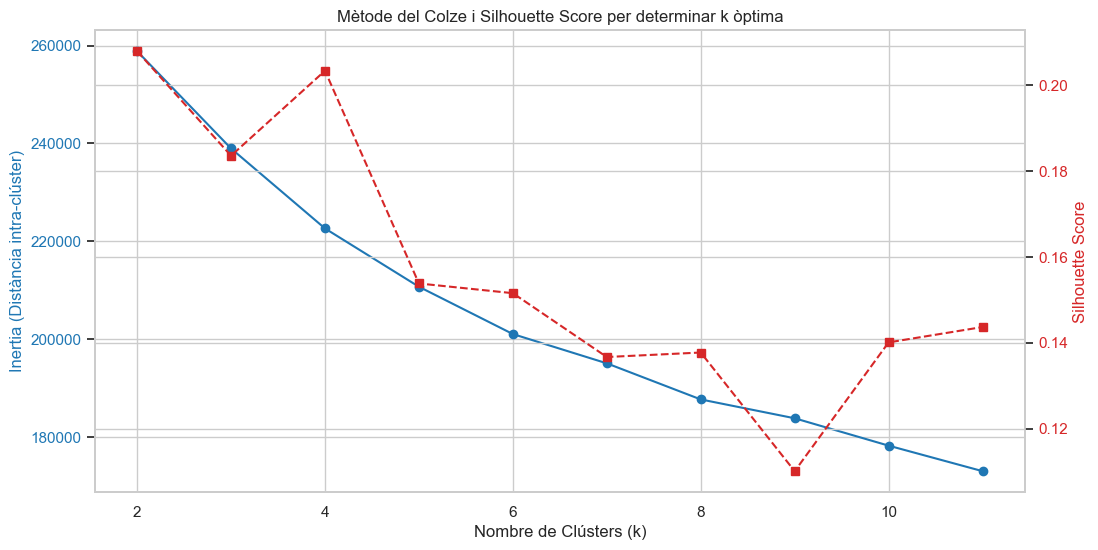

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gràfica 1: Inèrcia (El Colze)
color = 'tab:blue'
ax1.set_xlabel('Nombre de Clústers (k)')
ax1.set_ylabel('Inertia (Distància intra-clúster)', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Gràfica 2: Silhouette Score (Qualitat de separació)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Mètode del Colze i Silhouette Score per determinar k òptima')
plt.grid(True)
plt.show()

## Entrenem model

Procedim a entrenar el model amb la K òptima.

In [11]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

Reduim la dimensionalitat per visualitzar-ho.

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

Mostrem el PCA.

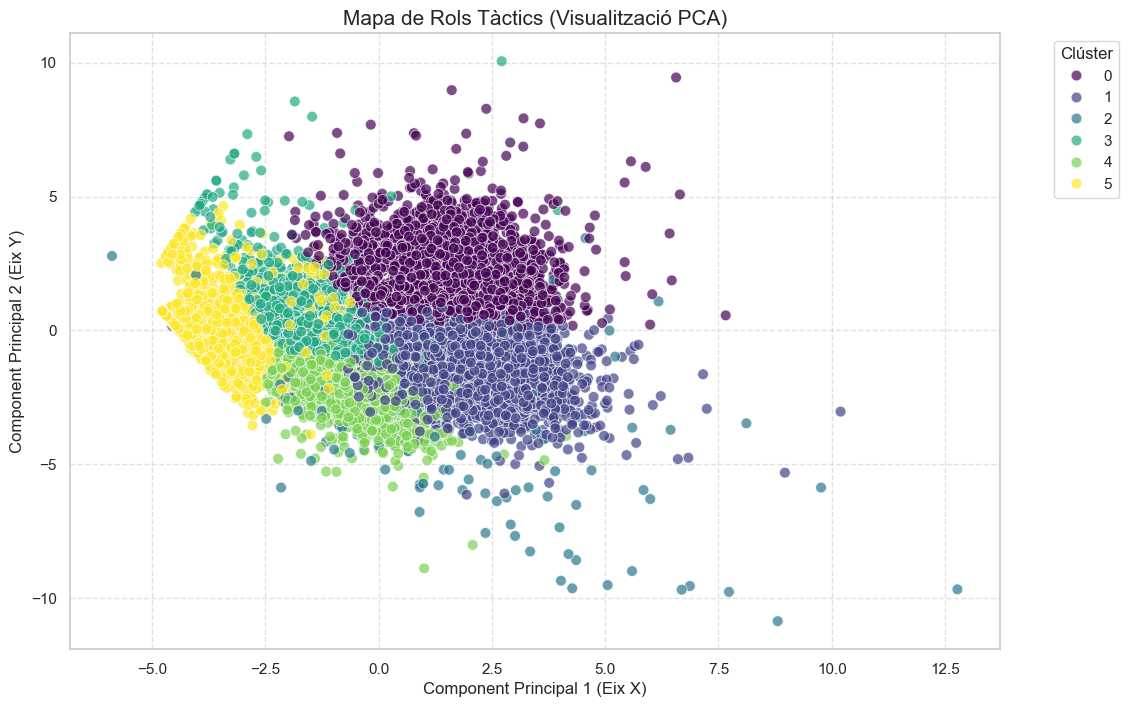

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=df, palette='viridis', alpha=0.7, s=60)
plt.title('Mapa de Rols Tàctics (Visualització PCA)', fontsize=15)
plt.xlabel('Component Principal 1 (Eix X)')
plt.ylabel('Component Principal 2 (Eix Y)')
plt.legend(title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Identifiquem clusters

Agrupem els clusters per la mediana d'aquestes columnes i ho mostrem.

In [14]:
perfil_clusters = df.groupby('cluster')[features_model].mean().round(2)
display(perfil_clusters)

,oer,der_proxy,ts_pct,usage_2p,usage_3p,ftr,pct_interior_usage,pct_exterior_usage,pct_shots_corner3,eff_paint,eff_mid,eff_corner3,eff_ab3,pts_p40,orb_p40,drb_p40,ast_p40,stl_p40,blk_p40,tov_p40,pfd_p40,fga_p40,3pa_p40,fta_p40
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,0.89,0.41,0.48,0.44,0.56,0.25,0.34,0.66,0.06,0.50,0.30,0.31,0.33,14.21,1.44,4.14,2.79,1.72,0.19,2.84,3.20,13.27,7.32,3.23
1,1.06,0.68,0.50,0.82,0.18,0.39,0.70,0.30,0.01,0.57,0.30,0.10,0.26,14.12,3.15,6.01,2.18,1.56,0.54,3.14,4.11,11.89,2.15,4.52
2,0.10,-0.28,0.54,0.39,0.25,2.06,0.10,0.08,0.01,0.06,0.01,0.01,0.02,17.09,2.82,4.44,1.57,1.17,0.45,2.96,11.18,7.38,3.12,22.11
3,0.85,0.40,0.47,0.44,0.56,0.24,0.00,0.01,0.00,0.00,0.00,0.00,0.00,13.37,1.27,4.00,2.65,1.77,0.15,2.88,3.11,13.22,7.32,2.98
4,1.03,0.68,0.50,0.83,0.16,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.39,3.00,6.01,1.99,1.50,0.48,3.08,3.88,11.48,1.92,4.07
5,0.12,0.46,0.07,0.39,0.28,0.06,0.06,0.07,0.00,0.02,0.01,0.00,0.01,1.10,1.07,2.62,1.37,1.16,0.13,2.93,1.08,6.07,2.32,0.40


Farem un mapa de calor per veure-ho millor.

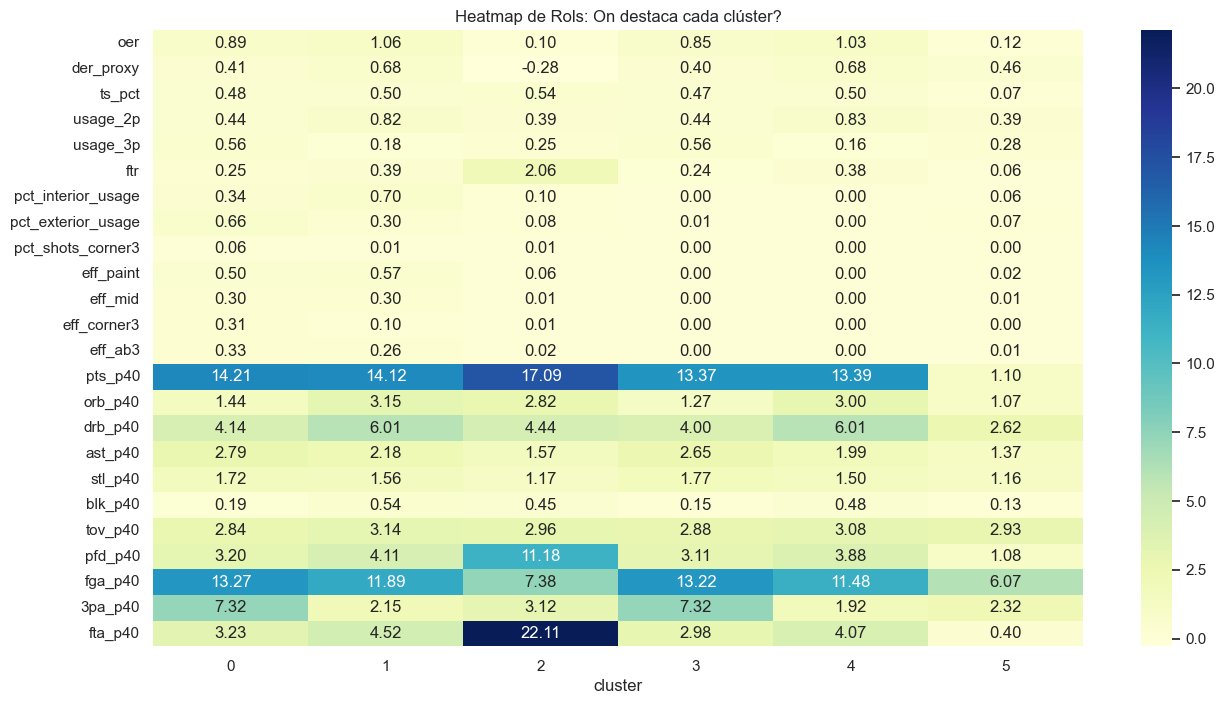

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(perfil_clusters.T, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Heatmap de Rols: On destaca cada clúster?")
plt.show()

## Comparació amb el model DBSCAN

Entrenem el model.

In [16]:
dbscan = DBSCAN(eps=3, min_samples=5) 
df['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

Mostrem resultats.

Clústers trobats per DBSCAN: [ 0  1 -1  4  3  2  6  5]
Jugadors marcats com a soroll: 1006


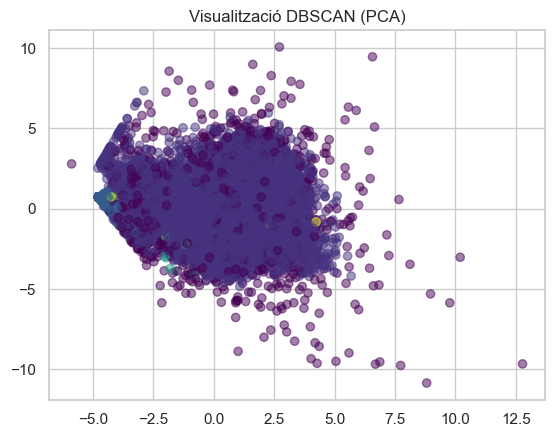

In [17]:
# Mirem quants clústers ha creat (el -1 és soroll)
print("Clústers trobats per DBSCAN:", df['cluster_dbscan'].unique())
print("Jugadors marcats com a soroll:", len(df[df['cluster_dbscan'] == -1]))

# Visualitzem la comparativa
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster_dbscan'], cmap='viridis', alpha=0.5)
plt.title("Visualització DBSCAN (PCA)")
plt.show()

## Visualització i Anàlisi dels Resultats

Importem les llibreries necessàries.

In [18]:
from sklearn.manifold import TSNE

Realitzarem un t-sne per veure la distribucio de les clusters.

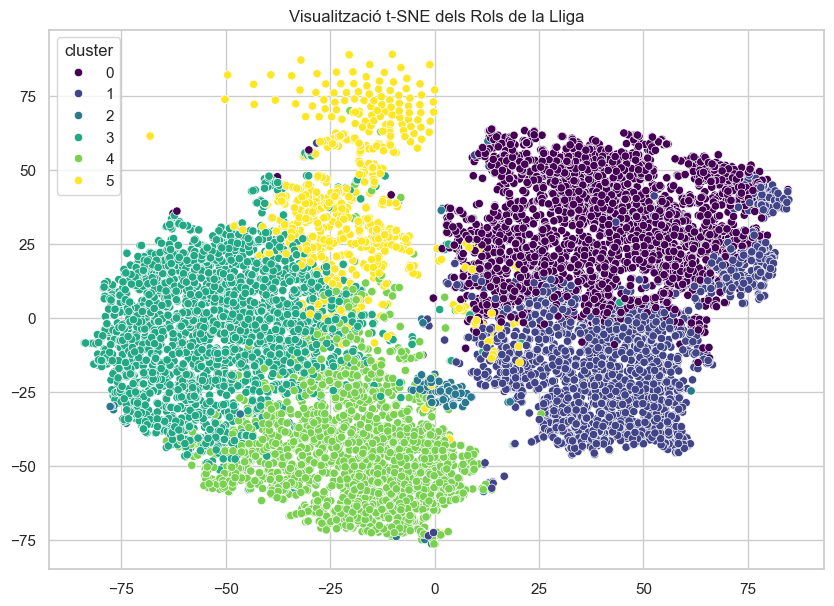

In [19]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualització
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster'], palette='viridis', legend='full')
plt.title('Visualització t-SNE dels Rols de la Lliga')
plt.show()

Ara farem uns plots per veure les dades de partida i els resultats obtinguts.

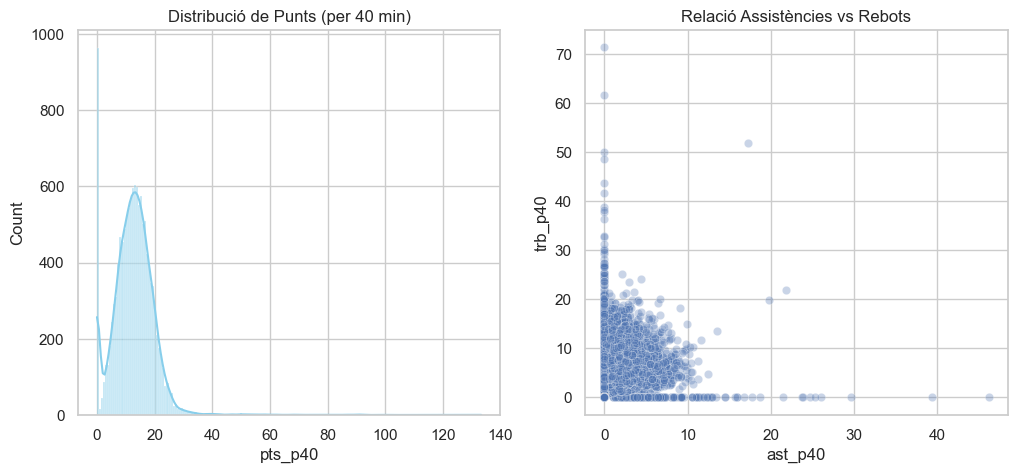

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['pts_p40'], kde=True, color='skyblue')
plt.title('Distribució de Punts (per 40 min)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='ast_p40', y='trb_p40', alpha=0.3)
plt.title('Relació Assistències vs Rebots')
plt.show()

Veiem els plots amb els resultats del KMeans.

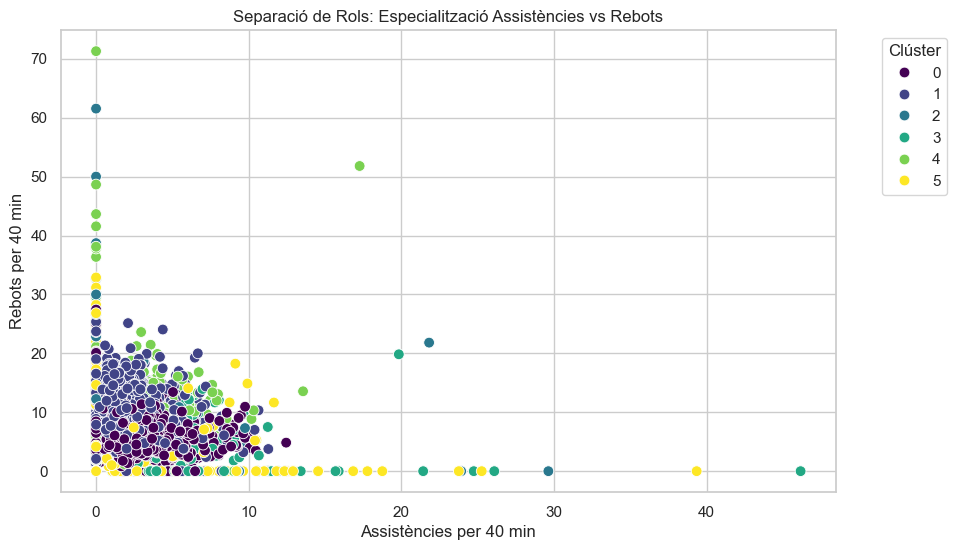

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ast_p40', y='trb_p40', hue='cluster', palette='viridis', s=60)
plt.title('Separació de Rols: Especialització Assistències vs Rebots')
plt.xlabel('Assistències per 40 min')
plt.ylabel('Rebots per 40 min')
plt.legend(title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\iruiz\AppData\Local\Temp\ipykernel_26100\4253718116.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='pts_p40', data=df, palette='Set3')


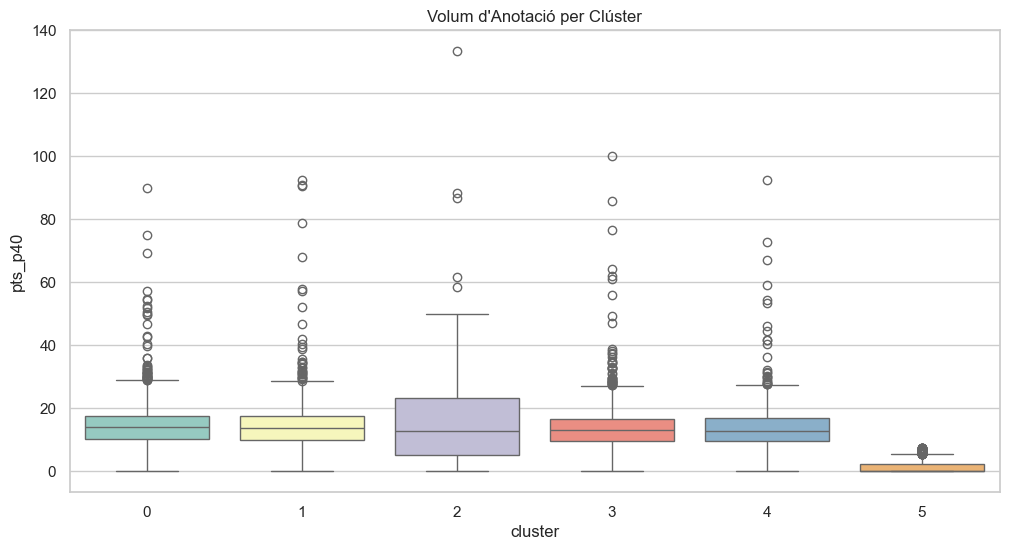

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='pts_p40', data=df, palette='Set3')
plt.title('Volum d\'Anotació per Clúster')
plt.show()

Ara veurem un radar per veure la separacio entre els rols, importem una llibreria matematica.

In [26]:
from math import pi

Seleccionem les 5 mètriques que millor defineixen un rol.

In [27]:
categories = ['pts_p40', 'ast_p40', 'trb_p40', 'usage_3p', 'oer']
N = len(categories)

Preparem les dades: mitjanes per clúster normalitzades (0 a 1).

In [28]:
df_radar = df.groupby('cluster')[categories].mean()
df_radar = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())

Configurem el gràfic.

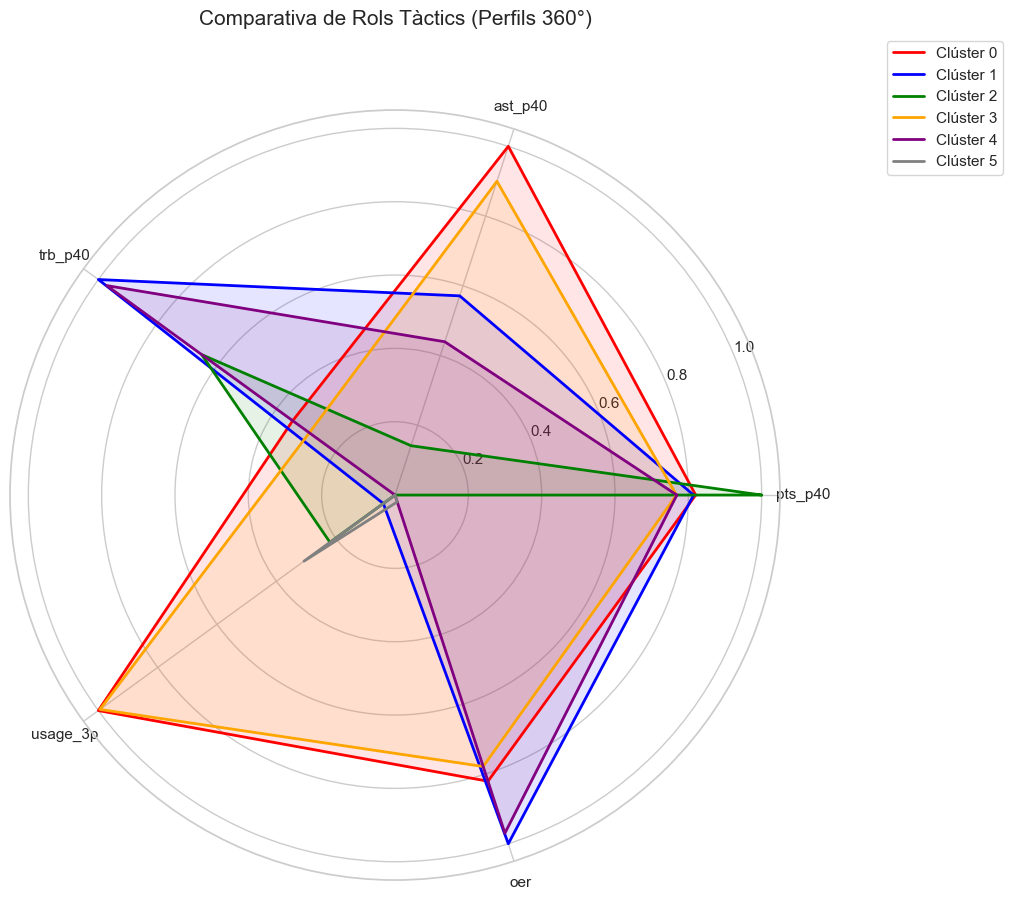

In [31]:
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
for i in range(6):
    values = df_radar.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Clúster {i}', color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Comparativa de Rols Tàctics (Perfils 360°)', size=15, y=1.1)
plt.show()